In [ ]:
# Empezar modelo NLP - Machine Learning

#### Libraries

In [3]:
import pandas as pd
import numpy as np
import re
import pickle

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from nltk.classify import ClassifierI
from statistics import mode

from tqdm import tqdm
tqdm.pandas()

from wordcloud import WordCloud
import matplotlib.pyplot as plt

C:\Users\oosca\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


#### Datasets

In [4]:
phrases1 = pd.read_csv("../Dataset/Suicidal phrases/dataset2.csv")
phrases = pd.read_csv("../Dataset/Suicidal phrases/dataset1.csv") #no hay NaN. Target 0: depresión. 1: bien. 11434 rows
phrases3 = pd.read_csv("../Dataset/Suicidal phrases/dataset3.csv")

In [25]:
phrases.head(7)

,Id,Text,Target
0,289612631038361600,Argh.. I hate my life,0
1,289612727654170624,I'm good,1
2,289612736063758337,Enjoy my life,1
3,289612773716008960,RT : I do what I want,1
4,289612819807211520,My life is just a series of unfortunate fucked...,0
5,289612853529432064,Im tryna become better everyday I open my eyes...,1
6,289613134543613952,RT : I hate how much I over-think at night,0


In [9]:
# Let's create the DataFrame

phrases_t = phrases['Text']
phrases_t

0                                    Argh.. I hate my life
1                                                 I'm good
2                                            Enjoy my life
3                                    RT : I do what I want
4        My life is just a series of unfortunate fucked...
                               ...                        
11429    ajhg;dfakjh;ajh;a i'm so disappointed in mysel...
11430                                  RT : I suck at life
11431    My Life Is The Shit I Guess That This Was Mean...
11432                                        I hate myself
11433                                    I feel depressed,
Name: Text, Length: 11434, dtype: object

In [23]:
phrases_t = phrases['Text']
phrases_t[6]

'RT : I hate how much I over-think at night'

#### Cleaning Dataset and rows

In [11]:
def remove_by_regex(tweet, regexp):
        return re.sub(regexp, '', tweet)

def remove_special_char(tweet):
    return re.sub(r"[^a-zA-Z0-9 ]", " ", tweet) #add space placeholder

def remove_numbers(tweet):
    return remove_by_regex(tweet, re.compile(r"[1234567890]"))

def remove_rt(tweet):
    return remove_by_regex(tweet, re.compile(r'RT(\s*)'))

def clean_up(tweet):
    tweet = remove_numbers(tweet)
    tweet = remove_special_char(tweet)
    tweet = remove_rt(tweet)
    return tweet.lower().strip()

In [22]:
phrases_text = phrases_t.apply(clean_up)
phrases_text[6]

'i hate how much i over think at night'

#### Tokenize & Lemmatize (lemma to do later)

In [13]:
tokenized = phrases_text.apply(word_tokenize)

In [13]:
# porter_text = tokenized.apply(PorterStemmer.stem(tokenized))

# lemmatizer = tokenized.apply(WordNetLemmatizer) 

#### Remove stopwords

In [14]:
#And we are going to create a function that removes stopwords

stopwords_list = set(stopwords.words('english'))

def remove_stopwords(tweet):
    return [x for x in tweet if x not in stopwords_list]

In [15]:
f = tokenized.apply(remove_stopwords)

In [21]:
f[6]

['hate', 'much', 'think', 'night']

In [17]:
# compiling feature lists of words from positive reviews and words from the negative tweets 
#to hopefully see trends in specific types of words in positive or negative tweets.

all_words = []
for index, value in f.iteritems():
    if value not in all_words:
        all_words += value

word_features = [x[0] for x in nltk.FreqDist(all_words).most_common(3000)]

In [18]:
word_features

['life',
 'good',
 'happy',
 'love',
 'hate',
 'want',
 'god',
 'blessed',
 'feel',
 'fuck',
 'sad',
 'blessing',
 'thanks',
 'deserve',
 'best',
 'great',
 'everything',
 'bad',
 'like',
 'friends',
 'ever',
 'really',
 'fine',
 'shit',
 'get',
 'know',
 'boring',
 'worst',
 'fucking',
 'much',
 'lol',
 'always',
 'tripping',
 'need',
 'proud',
 'awesome',
 'meekmill',
 'person',
 'im',
 'sucks',
 'never',
 'perfect',
 'got',
 'girl',
 'people',
 'think',
 'thank',
 'stressed',
 'change',
 'use',
 'man',
 'depressed',
 'live',
 'one',
 'ugly',
 'things',
 'feeling',
 'beautiful',
 'amazing',
 'die',
 'thankful',
 'suck',
 'nothing',
 'damn',
 'mood',
 'pretty',
 'dont',
 'could',
 'time',
 'way',
 'world',
 'omg',
 'reiatable',
 'complete',
 'wish',
 'yeah',
 'true',
 'oh',
 'day',
 'haha',
 'yes',
 'still',
 'make',
 'headache',
 'cause',
 'say',
 'loving',
 'living',
 'right',
 'swear',
 'single',
 'truly',
 'everyone',
 'thing',
 'every',
 'sick',
 'actually',
 'even',
 'honestly',

#### Find features

In [19]:
# Next, we're going to build a quick function that will find these top 3,000 words 
# in our positive and negative documents, marking their presence as either positive or negative:

def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

In [20]:
# we can do this for all of our documents, saving the feature existence booleans 
# and their respective positive or negative categories by doing:

features_f = f.apply(find_features)

# Convert the list of dictionaries to dataframe: 

features_new = pd.DataFrame.from_dict(list(features_f), orient="columns")

# Create the column Target in the new dataframe:

features_new['Target'] = phrases['Target']

In [21]:
features_new

,life,good,happy,love,hate,want,god,blessed,feel,fuck,...,cain,nooo,wio,hunna,contradict,elf,tonight,contemplate,linddsey,Target
0,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11429,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
11430,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
11431,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
11432,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


#### Data splitting

In [22]:
# Let's split the x and y. Also the training and testing set:

X = features_new.drop(columns="Target")
y = features_new["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

#### Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_train, y_train)

0.829986169572608

#### Random Forest

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [20]:
rf.score(X_train, y_train)

0.9381157841810482

#### Random Forest Classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

rfclass = RandomForestClassifier(n_estimators=1000, random_state=42)
rfclass.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [22]:
rfclass.score(X_train, y_train)

0.9834918552530885

In [23]:
# Save Random Forest Classifier in pickle:

rfclass_model = 'rfclass_model.sav'
pickle.dump(rfclass, open(rfclass_model, 'wb'))

In [24]:
# Load the model:

loaded_rfclass = pickle.load(open('rfclass_model.sav', 'rb'))
result_rfclass = loaded_rfclass.score(X_test, y_test)
print(result_rfclass)

0.9457804984696109


#### KNN Classifier

In [25]:
n_neighbors = 7

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.94
Accuracy of K-NN classifier on test set: 0.92


In [26]:
# Save the pickle knn:

knn_model = 'knn_model.sav'
pickle.dump(knn, open(knn_model, 'wb'))

In [25]:
loaded_knn = pickle.load(open('knn_model.sav', 'rb'))
result_knn = loaded_knn.score(X_test, y_test)
print(result_knn)

0.9239177962396152


In [ ]:
------------------------

#### Creating a module for Sentiment Analysis with NLTK

In [36]:
def sentiment_rf(text):
    #hacer preprocessing aqui dentro
    clean_text = word_tokenize(text.lower())
    feats = pd.Series(clean_text).apply(find_features)
    feats = pd.DataFrame.from_dict(list(feats), orient='columns')
    return loaded_rfclass.predict(feats)

In [68]:
def sentiment_knn(text):
    #hacer preprocessing aqui dentro
    clean_text = word_tokenize(text.lower())
    feats = pd.Series(clean_text).apply(find_features)
    feats = pd.DataFrame.from_dict(list(feats), orient='columns')
    feats = feats.reshape(1, -1)
    print(loaded_knn.predict(pd.DataFrame(feats.sum())))
    return loaded_knn.predict(feats)



In [1]:
# With that, we can now use this file, and the sentiment function as a module. 

### Graphs time

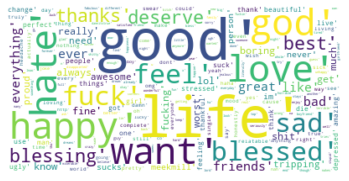

<Figure size 432x288 with 0 Axes>

In [63]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords_list, background_color="white").generate(str(word_features))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
# plt.figure(figsize=(40, 30))
plt.axis("off")
plt.show()
plt.savefig("sentiment_words.png")

<Figure size 432x288 with 0 Axes>